In [ ]:
import pandas as pd
import requests
import cv2
from deepface import DeepFace
import numpy as np
import datetime
import random
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import traceback
import os


# ----------------------------
# Helper Functions for File Paths
# ----------------------------
def get_sanitized_name(name):
    """
    Converts a human-readable product name for drinks into a filename-safe string.
    Replaces spaces and hyphens with single underscores.
    """
    # Replace all spaces and hyphens with a single underscore
    sanitized_name = name.replace(' ', '_').replace('-', '_')
    # Replace any double underscores that might result from the previous step
    while '__' in sanitized_name:
        sanitized_name = sanitized_name.replace('__', '_')
    return sanitized_name

def get_pastry_filename(name):
    """
    Returns the exact pastry name for the file path, as it contains spaces.
    """
    return name

# ----------------------------
# Enhanced Emotion Processing
# ----------------------------
class EmotionProcessor:
    """Compensates for DeepFace limitations with psychological insights"""
    EMOTION_HIERARCHY = {
        'angry': 0.9,     # Highest priority
        'fear': 0.85,
        'sad': 0.8,
        'disgust': 0.75,
        'surprise': 0.7,
        'happy': 0.65,    # Lower priority - people often mask true feelings
        'neutral': 0.5
    }

    EMOTION_GROUPS = {
        'positive': ['happy', 'surprise'],
        'negative': ['angry', 'sad', 'fear', 'disgust'],
        'neutral': ['neutral']
    }

    COMPLEX_EMOTION_RULES = {
        # Sadness + Fear = Anxious (قلق)
        'anxious': lambda emotions: emotions.get('sad', 0) > 20 and emotions.get('fear', 0) > 20,
        # Neutral + low overall scores = Bored (ملل)
        'bored': lambda emotions: emotions.get('neutral', 0) > 50 and sum(emotions.values()) < 70,
        # Happy + Calm = Relaxed (استرخاء)
        'relaxed': lambda emotions: emotions.get('happy', 0) > 30 and emotions.get('calm', 0) > 30,
        # Angry + high overall scores = Stressed (توتر)
        'stressed': lambda emotions: emotions.get('angry', 0) > 30 and sum(emotions.values()) > 80,
    }

    @staticmethod
    def enhance_emotion_detection(raw_emotions):
        """Apply psychological insights to refine emotion detection"""
        # Apply hierarchy weights
        weighted_emotions = {e: s * EmotionProcessor.EMOTION_HIERARCHY.get(e, 0.5)
                             for e, s in raw_emotions.items()}

        # Normalize
        total = sum(weighted_emotions.values())
        if total == 0:
            return raw_emotions

        enhanced = {e: s/total * 100 for e, s in weighted_emotions.items()}

        # Infer complex emotions
        inferred_mood = None
        for mood, rule in EmotionProcessor.COMPLEX_EMOTION_RULES.items():
            if rule(enhanced):
                inferred_mood = mood
                break

        if inferred_mood:
            # Rebalance scores based on inferred mood
            print(f"Inferred complex mood: {inferred_mood}")
            for emotion in enhanced:
                enhanced[emotion] = enhanced.get(emotion, 0) * 0.5  # Reduce other scores
            enhanced[inferred_mood] = 50.0 # Set inferred mood score high

        return enhanced

    @staticmethod
    def get_emotion_group(emotions):
        """Determine dominant emotion group"""
        # Check for complex emotions first
        dominant_emotion = max(emotions, key=emotions.get)
        if dominant_emotion in ['bored', 'anxious', 'relaxed', 'stressed']:
            if dominant_emotion in ['anxious', 'stressed', 'bored']:
                return 'negative'
            elif dominant_emotion == 'relaxed':
                return 'positive'

        # Fallback to basic groups
        group_scores = {g: 0 for g in EmotionProcessor.EMOTION_GROUPS}
        for emotion, score in emotions.items():
            for group, emotions_in_group in EmotionProcessor.EMOTION_GROUPS.items():
                if emotion in emotions_in_group:
                    group_scores[group] += score

        return max(group_scores, key=group_scores.get)

# ----------------------------
# Context Analyzer
# ----------------------------
class ContextAnalyzer:
    """Analyzes contextual factors for recommendations"""
    TIME_CATEGORIES = {
        'morning': (6, 12),
        'afternoon': (12, 18),
        'evening': (18, 22),
        'night': (22, 6)
    }

    SEASON_MONTHS = {
        'winter': [11, 12, 1, 2],
        'spring': [3, 4, 5],
        'summer': [6, 7, 8],
        'fall': [9, 10]
    }

    @staticmethod
    def analyze_context():
        """Analyze current context"""
        now = datetime.now()
        current_hour = now.hour
        current_month = now.month

        # Determine time category
        time_category = 'night'
        for cat, (start, end) in ContextAnalyzer.TIME_CATEGORIES.items():
            if end > start:
                if start <= current_hour < end:
                    time_category = cat
            else:  # Overnight
                if current_hour >= start or current_hour < end:
                    time_category = cat

        # Determine season
        season = 'summer'
        for s, months in ContextAnalyzer.SEASON_MONTHS.items():
            if current_month in months:
                season = s

        # Weather
        current_temp = ContextAnalyzer.get_weather()
        weather_condition = 'Hot' if current_temp > 25 else 'Cold'

        return {
            'time_category': time_category,
            'season': season,
            'temperature': current_temp,
            'weather_condition': weather_condition,
            'weekend': now.weekday() >= 5  # Saturday or Sunday
        }

    @staticmethod
    def get_weather():
        """Get current weather"""
        API_KEY = "        CITY = "Jeddah"

        url = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"
        try:
            response = requests.get(url, timeout=3)
            data = response.json()
            if response.status_code == 200 and "main" in data:
                return data["main"]["temp"]
        except:
            return 28  # Default temperature

# ----------------------------
# Recommendation Engine
# ----------------------------
class RecommendationEngine:
    """Advanced drink recommendation system"""
    def __init__(self, df_drinks, df_pastries, df_mood_prefs):
        self.df_drinks = df_drinks
        self.df_pastries = df_pastries
        self.last_recommendations = []
        self.diversity_factor = 0.25

        # Create mood preference vectors
        self.mood_trait_vectors = {}
        for _, row in df_mood_prefs.iterrows():
            vector = []
            for trait in ['acidity', 'aroma', 'bitterness', 'sweetness', 'body']:
                # Create consistent hash values for traits
                trait_value = row[f'{trait}_preference']
                vector.append(hash(trait_value) % 100)
            self.mood_trait_vectors[row['mood']] = vector

    def recommend_drink(self, mood_profile, customer_age, context):
        """Generate drink recommendation with advanced logic"""
        # Enhanced emotion processing
        enhanced_emotions = EmotionProcessor.enhance_emotion_detection(mood_profile)
        emotion_group = EmotionProcessor.get_emotion_group(enhanced_emotions)

        print(f"\n--- Context Analysis ---")
        print(f"    Enhanced Mood: {enhanced_emotions}")
        print(f"    Emotion Group: {emotion_group}")
        print(f"    Age: {customer_age} years")
        print(f"    Time: {context['time_category']}")
        print(f"    Season: {context['season']}")
        print(f"    Weather: {context['weather_condition']} ({context['temperature']}°C)")
        print(f"    Weekend: {context['weekend']}")

        # Create working copy
        df_scored = self.df_drinks.copy()

        # 1. Mood Matching (Advanced)
        df_scored['mood_score'] = df_scored.apply(
            lambda row: self.calculate_mood_score(row, enhanced_emotions, emotion_group),
            axis=1
        )

        # 2. Contextual Matching
        df_scored['context_score'] = df_scored.apply(
            lambda row: self.calculate_context_score(row, context, customer_age),
            axis=1
        )

        # 3. Business Factors
        max_profit = df_scored['profit_margine'].max()
        df_scored['profit_score'] = df_scored['profit_margine'] / max_profit

        # 4. Diversity Control
        df_scored['diversity_penalty'] = df_scored['product_id'].apply(
            lambda x: 0.7 if x in self.last_recommendations[-3:] else 1.0
        )

        # 5. Final Score
        df_scored['final_score'] = (
            (df_scored['mood_score'] * 0.5) +
            (df_scored['context_score'] * 0.3) +
            (df_scored['profit_score'] * 0.2)
        ) * df_scored['diversity_penalty']

        # Add randomness for diversity
        df_scored['final_score'] *= (1 + self.diversity_factor * (np.random.rand(len(df_scored)) - 0.5))

        # Sort and select
        df_sorted = df_scored.sort_values('final_score', ascending=False)

        # Print top recommendations
        print("\n--- Top Recommendations ---")
        print(df_sorted[['product_name', 'mood_score', 'context_score', 'profit_score', 'final_score']].head(5))

        # Select from top 3
        top_3 = df_sorted.head(3)
        recommended = top_3.sample(1)
        drink_id = recommended['product_id'].values[0]

        # Update recommendation history
        self.last_recommendations.append(drink_id)
        if len(self.last_recommendations) > 10:
            self.last_recommendations.pop(0)

        # Pastry recommendation
        pastry_rec = self.recommend_pastry(recommended, emotion_group)

        return recommended, pastry_rec

    def calculate_mood_score(self, drink, emotions, emotion_group):
        """Calculate mood compatibility score"""
        # 1. Trait matching with mood preferences
        mood_similarity = 0
        for mood, score in emotions.items():
            # Changed condition from 'score > 10' to 'score > 0.5' for better sensitivity
            if mood in self.mood_trait_vectors and score > 0.5:
                # Create consistent hash values for drink traits
                drink_vector = [hash(str(drink[t])) % 100 for t in ['acidity', 'aroma', 'bitterness', 'sweetness', 'body']]
                similarity = cosine_similarity([self.mood_trait_vectors[mood]], [drink_vector])[0][0]
                mood_similarity += similarity * (score / 100)

        # 2. Emotion group specific boosters
        group_boost = 0
        if emotion_group == 'negative':
            if 'comfort' in drink['mood_tags']:
                group_boost += 1.5
            if drink['sweetness'] in ['high', 'medium']:
                group_boost += 1.0
        elif emotion_group == 'positive':
            # Positive emotions get boost from balanced profiles
            if 'balanced' in drink['mood_tags']:
                group_boost += 1.2
        else:  # neutral
            if 'balanced' in drink['mood_tags']:
                group_boost += 1.0

        # 3. Dominant emotion specific rules
        dominant_emotion = max(emotions, key=emotions.get)
        emotion_rules = {
            'sad': {'bitterness': ['low'], 'sweetness': ['high', 'medium']},
            'angry': {'aroma': ['strong'], 'body': ['full']},
            'happy': {'sweetness': ['medium'], 'body': ['medium']},
            'fear': {'body': ['light']},
            'bored': {'aroma': ['strong'], 'sweetness': ['high']},
            'anxious': {'body': ['light'], 'aroma': ['faint']},
            'relaxed': {'aroma': ['balanced'], 'sweetness': ['mild']},
            'stressed': {'bitterness': ['strong'], 'body': ['full']}
        }

        emotion_match = 0
        if dominant_emotion in emotion_rules:
            for trait, values in emotion_rules[dominant_emotion].items():
                if trait in drink and drink[trait] in values:
                    emotion_match += 1.0

        return mood_similarity + group_boost + emotion_match

    def calculate_context_score(self, drink, context, age):
        """Calculate context compatibility score"""
        score = 1.0

        # Time of day scoring (removed caffeine references)
        time_rules = {
            'morning': {'aroma': 'strong', 'body': 'full'},
            'afternoon': {'hot_or_cold': 'Cold', 'body': 'medium'},
            'evening': {'body': 'light'},
            'night': {'body': 'light'}
        }

        time_cat = context['time_category']
        if time_cat in time_rules:
            for trait, value in time_rules[time_cat].items():
                if trait in drink and drink[trait] == value:
                    score += 0.8

        # Weather scoring
        if context['weather_condition'] == 'Hot':
            if 'hot_or_cold' in drink and drink['hot_or_cold'] == 'Cold':
                score += 1.0
        else:
            if 'hot_or_cold' in drink and drink['hot_or_cold'] == 'Hot':
                score += 1.0

        # Seasonal adjustments
        if 'hot_or_cold' in drink:
            if context['season'] == 'winter' and drink['hot_or_cold'] == 'Hot':
                score += 0.5
            elif context['season'] == 'summer' and drink['hot_or_cold'] == 'Cold':
                score += 0.5

        # Weekend scoring
        if context['weekend']:
            if 'mood_tags' in drink and 'indulgent' in drink['mood_tags']:
                score += 0.7
        else:  # Weekday
            if 'mood_tags' in drink and 'energizing' in drink['mood_tags']:
                score += 0.5

        # Age scoring (simplified without caffeine)
        if age < 18:
            if 'main_catagory' in drink and drink['main_catagory'] == 'Decaf_Beverages':
                score += 2.0  # Big boost for decaf for kids
            elif 'sweetness' in drink and drink['sweetness'] in ['high', 'medium']:
                score += 1.0 # Boost for sweet things
            else:
                score *= 0.1 # Penalize other types of drinks

        return score

    def recommend_pastry(self, drink, emotion_group):
        """Recommend pastry based on drink and mood, with mood-based probability"""
        if self.df_pastries.empty:
            return ""

        # Probability for pastry recommendation based on emotion group
        pastry_probability = 0.7 if emotion_group == 'negative' else 0.3

        if random.random() > pastry_probability:
            return ""

        df_scored = self.df_pastries.copy()

        # Create pairing scores
        drink_name = drink['product_name'].values[0]
        sweetness = drink['sweetness'].values[0] if 'sweetness' in drink else 'medium'
        bitterness = drink['bitterness'].values[0] if 'bitterness' in drink else 'medium'

        # Complementary pairing logic
        if bitterness in ['high', 'medium']:
            df_scored['pairing_score'] = df_scored['Product_Name'].apply(
                lambda x: 3.0 if 'Chocolate' in str(x) else 2.0 if 'Caramel' in str(x) else 1.0
            )
        elif sweetness in ['high', 'medium']:
            df_scored['pairing_score'] = df_scored['Product_Name'].apply(
                lambda x: 2.5 if any(w in str(x) for w in ['Croissant', 'Bread']) else 1.0
            )
        else:
            df_scored['pairing_score'] = 1.0

        # Mood-based scoring
        if emotion_group == 'negative':
            df_scored['mood_score'] = df_scored['Product_Name'].apply(
                lambda x: 3.0 if any(w in str(x) for w in ['Chocolate', 'Brownie', 'Cheesecake']) else 1.0
            )
        else:
            df_scored['mood_score'] = 1.0

        # Final score
        df_scored['final_score'] = df_scored['pairing_score'] * df_scored['mood_score'] * np.random.rand(len(df_scored))
        top_pastry = df_scored.nlargest(1, 'final_score')

        if not top_pastry.empty:
            return top_pastry['Product_Name'].values[0]
        else:
            return ""

# ----------------------------
# Data Loading Function
# ----------------------------
def load_data():
    """Load all required data files"""
    df_profit, df_catalog, df_traits, df_mood_prefs = None, None, None, None
    df_pastries = pd.DataFrame() # Default to empty dataframe

    try:
        df_profit = pd.read_csv('profit_margin.csv')
        df_catalog = pd.read_csv('product_catalog.csv')
        df_traits = pd.read_csv('coffee_traits.csv')
        df_mood_prefs = pd.read_csv('mood_preferences.csv')
        print("Successfully loaded core data files.")
    except Exception as e:
        print(f"Error loading a core data file: {e}")
        return None, None, None, None

    try:
        df_pastries = pd.read_csv('pastries.csv')
        df_pastries.columns = df_pastries.columns.str.strip()
        df_pastries['Product_Name'] = df_pastries['Product_Name'].astype(str)
        print("Successfully loaded pastries data.")
    except FileNotFoundError:
        print("pastries.csv not found. Continuing without pastry recommendations.")
    except Exception as e:
        print(f"Error loading pastries.csv: {e}")
        print("Continuing without pastry recommendations.")

    # Clean column names
    for df in [df_profit, df_catalog, df_traits, df_mood_prefs]:
        df.columns = df.columns.str.strip()

    # Clean product catalog - remove empty rows
    df_catalog = df_catalog.dropna(subset=['product_id'])
    df_catalog = df_catalog[df_catalog['product_id'].notna()]

    # "Spanish Latte" inconsistency
    # The 'product_name' column should contain the human-readable name,
    # which is used for display. The code will handle converting this to a
    # filename path.
    df_catalog.loc[df_catalog['product_name'] == 'Spanish_Latte', 'product_name'] = 'Spanish Latte'

    # Drop duplicate column in traits if it exists
    if 'hot_or_cold' in df_traits.columns:
        df_traits = df_traits.drop('hot_or_cold', axis=1)

    # Add dummy 'caffeine_level' column if it's missing to prevent crash
    if 'caffeine_level' not in df_traits.columns:
        df_traits['caffeine_level'] = 'medium'
        print("Warning: 'caffeine_level' column not found. Adding a default 'medium' level.")

    # Merge datasets
    df_merged = pd.merge(df_catalog, df_traits, on='product_id')
    df_drinks = pd.merge(df_merged, df_profit, on='product_id')

    # Convert calories to numeric and fill missing values
    if 'calories' in df_drinks:
        df_drinks['calories'] = pd.to_numeric(df_drinks['calories'], errors='coerce')
    else:
        df_drinks['calories'] = 200  # Default column

    df_drinks['calories'] = df_drinks['calories'].fillna(200)

    # Add psychological tags
    df_drinks['mood_tags'] = df_drinks.apply(
        lambda row: [
            'comfort' if row['sweetness'] in ['high', 'medium'] else '',
            'energizing' if row['caffeine_level'] == 'high' else '',
            'relaxing' if row['caffeine_level'] == 'low' else '',
            'indulgent' if 'calories' in row and row['calories'] > 200 else ''
        ], axis=1
    )

    print("Successfully merged all drink data.")
    print(f"Loaded {len(df_drinks)} drinks")

    return df_drinks, df_pastries, df_mood_prefs

# ----------------------------
# Print Functionality
# ----------------------------
def print_final_order(file_path, item_name):
    """Simulates printing a single image with its order name."""
    # Standardize the path to use forward slashes for cross-platform compatibility
    normalized_path = file_path.replace('\\', '/')
    if not os.path.exists(normalized_path):
        print(f"Error: The image file '{normalized_path}' does not exist. Cannot print.")
        return

    print(f"Printing image: {normalized_path} with order name: {item_name}")
    print("--- Printing Complete ---")


# ----------------------------
# Main Execution
# ----------------------------
def main():
    # Load data
    df_drinks, df_pastries, df_mood_prefs = load_data()

    # Exit if data loading failed
    if df_drinks is None or df_mood_prefs is None:
        print("Exiting due to data loading errors")
        return

    # Analyze context
    context = ContextAnalyzer.analyze_context()

    # Initialize engine
    engine = RecommendationEngine(df_drinks, df_pastries, df_mood_prefs)

    print("\nWelcome to the Emotional Barista™ System")
    print("Choose interaction method:")
    print("1 - Camera (real-time analysis)")
    print("2 - Static image")
    print("3 - Manual emotion input")
    print("q - Exit")

    choice = input("Enter option: ")

    if choice == '1':
        # Camera mode
        print("\nStarting camera. Press 'r' to capture, 'q' to quit.")
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Error: Camera not accessible")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            cv2.imshow('Emotional Barista™', frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('r'):
                try:
                    # Analyze face
                    results = DeepFace.analyze(frame, actions=['emotion', 'age'],
                                             enforce_detection=False, silent=True)
                    if not results:
                        raise ValueError("No face detected")
                    result = results[0]

                    # Process emotions
                    raw_emotions = result['emotion']
                    age = result['age']
                    enhanced_emotions = EmotionProcessor.enhance_emotion_detection(raw_emotions)

                    print(f"\nEmotion Analysis:")
                    for e, s in enhanced_emotions.items():
                        print(f"  {e.capitalize()}: {s:.1f}%")

                    # Get recommendation
                    drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)

                    # Get the product name for display
                    drink_name = drink_rec['product_name'].values[0]

                    # Get the hot_or_cold value for the folder path
                    hot_or_cold = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "hot"
                    drink_type_folder = f"{hot_or_cold.lower()}_drinks"

                    # Sanitize the drink name for the filename
                    sanitized_drink_name = get_sanitized_name(drink_name)

                    if 'main_catagory' in drink_rec:
                        drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
                    else:
                        drink_type = "Regular"

                    temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"

                    output = (f"\n--- Your Emotional Barista Recommendation ---"
                              f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                              f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                              f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                              f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")

                    if pastry_rec:
                        output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"

                    print(output)

                    # --- New Printing Logic ---
                    # Use the hot_or_cold column to determine the subfolder
                    drink_image_path = os.path.join("static/barns_food_and_drink", drink_type_folder, f"{sanitized_drink_name}.png")
                    print_final_order(drink_image_path, drink_name)

                    # Use the raw name for the pastry
                    if pastry_rec:
                        pastry_image_path = os.path.join("static/barns_food_and_drink", "pastries", f"{pastry_rec}.png")
                        print_final_order(pastry_image_path, pastry_rec)

                except Exception as e:
                    print(f"Analysis error: {e}. Using fallback.")
                    print(traceback.format_exc())
                    fallback_emotions = {'neutral': 100}
                    # Assign both returned values
                    drink_rec, pastry_rec = engine.recommend_drink(fallback_emotions, 30, context)
                    # To fix the printing issue, replace underscores with spaces for the filename
                    drink_name = drink_rec['product_name'].values[0]
                    print(f"\nRecommended Drink: {drink_name}")
                    if pastry_rec:
                        print(f"Recommended Pastry: {pastry_rec}")

            elif key == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    elif choice == '2':
        # Static image mode
        path = input("Enter image path: ")
        try:
            img = cv2.imread(path)
            if img is None:
                raise ValueError("Image not found")

            # Analyze face
            results = DeepFace.analyze(img, actions=['emotion', 'age'],
                                     enforce_detection=False, silent=True)
            if not results:
                raise ValueError("No face detected")
            result = results[0]

            # Process emotions
            raw_emotions = result['emotion']
            age = result['age']
            enhanced_emotions = EmotionProcessor.enhance_emotion_detection(raw_emotions)

            print("\nEmotion Analysis:")
            for e, s in enhanced_emotions.items():
                print(f"  {e.capitalize()}: {s:.1f}%")

            # Get recommendation
            drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)

            # Get the product name for display
            drink_name = drink_rec['product_name'].values[0]

            # Get the hot_or_cold value for the folder path
            hot_or_cold = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "hot"
            drink_type_folder = f"{hot_or_cold.lower()}_drinks"

            # Sanitize the drink name for the filename
            sanitized_drink_name = get_sanitized_name(drink_name)

            if 'main_catagory' in drink_rec:
                drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
            else:
                drink_type = "Regular"

            temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"

            output = (f"\n--- Your Emotional Barista Recommendation ---"
                      f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                      f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                      f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                      f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")

            if pastry_rec:
                output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"

            print(output)

            # --- New Printing Logic ---
            # Use the hot_or_cold column to determine the subfolder
            drink_image_path = os.path.join("static/barns_food_and_drink", drink_type_folder, f"{sanitized_drink_name}.png")
            print_final_order(drink_image_path, drink_name)

            # Use the raw name for the pastry
            if pastry_rec:
                pastry_image_path = os.path.join("static/barns_food_and_drink", "pastries", f"{pastry_rec}.png")
                print_final_order(pastry_image_path, pastry_rec)

        except Exception as e:
            print(f"Error: {e}. Using fallback recommendation.")
            print(traceback.format_exc())
            fallback_emotions = {'neutral': 100}
            #  Assign both returned values
            drink_rec, pastry_rec = engine.recommend_drink(fallback_emotions, 30, context)
            # To fix the printing issue, replace underscores with spaces for the filename
            drink_name = drink_rec['product_name'].values[0]
            print(f"\nFallback Recommendation: {drink_name}")
            if pastry_rec:
                print(f"Recommended Pastry: {pastry_rec}")

    elif choice == '3':
        # Manual input mode
        print("\nEnter emotion percentages (sum to 100):")
        emotions = {}
        for e in ['happy', 'sad', 'angry', 'fear', 'disgust', 'surprise', 'neutral']:
            val = float(input(f"{e.capitalize()}: "))
            emotions[e] = val

        age = int(input("Enter age: "))
        enhanced_emotions = EmotionProcessor.enhance_emotion_detection(emotions)
        drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)

        # Get the product name for display
        drink_name = drink_rec['product_name'].values[0]

        # Get the hot_or_cold value for the folder path
        hot_or_cold = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "hot"
        drink_type_folder = f"{hot_or_cold.lower()}_drinks"

        # Sanitize the drink name for the filename
        sanitized_drink_name = get_sanitized_name(drink_name)

        if 'main_catagory' in drink_rec:
            drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
        else:
            drink_type = "Regular"

        temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"

        output = (f"\n--- Your Emotional Barista Recommendation ---"
                  f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                  f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                  f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                  f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")

        if pastry_rec:
            output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"

        print(output)

        # --- New Printing Logic ---
        # Use the hot_or_cold column to determine the subfolder
        drink_image_path = os.path.join("static/barns_food_and_drink", drink_type_folder, f"{sanitized_drink_name}.png")
        print_final_order(drink_image_path, drink_name)

        # Use the raw name for the pastry
        if pastry_rec:
            pastry_image_path = os.path.join("static/barns_food_and_drink", "pastries", f"{pastry_rec}.png")
            print_final_order(pastry_image_path, pastry_rec)
        

    elif choice == 'q':
        print("Goodbye!")
    else:
        print("Invalid option")

if __name__ == "__main__":
    main()


Successfully loaded core data files.
Successfully loaded pastries data.
Successfully merged all drink data.
Loaded 57 drinks

Welcome to the Emotional Barista™ System
Choose interaction method:
1 - Camera (real-time analysis)
2 - Static image
3 - Manual emotion input
q - Exit
Inferred complex mood: anxious

Emotion Analysis:
  Angry: 2.9%
  Disgust: 0.0%
  Fear: 29.5%
  Happy: 0.0%
  Sad: 15.8%
  Surprise: 0.2%
  Neutral: 1.7%
  Anxious: 50.0%

--- Context Analysis ---
    Enhanced Mood: {'angry': 4.0065429758506195, 'disgust': 1.0137526472696174e-05, 'fear': 37.81107099570963, 'happy': 0.0008714457958137844, 'sad': 19.01965146511103, 'surprise': 0.16510830400507023, 'neutral': 1.2615936146524853, 'anxious': 37.73515106134887}
    Emotion Group: negative
    Age: 29 years
    Time: afternoon
    Season: summer
    Weather: Hot (34.61°C)
    Weekend: False

--- Top Recommendations ---
                product_name  mood_score  context_score  profit_score  \
4                  Americano  

Successfully loaded core data files.
Successfully loaded pastries data.
Successfully merged all drink data.
Loaded 57 drinks

Welcome to the Emotional Barista™ System
Choose interaction method:
1 - Camera (real-time analysis)
2 - Static image
3 - Manual emotion input
q - Exit

Emotion Analysis:
  Angry: 0.0%
  Disgust: 0.0%
  Fear: 0.0%
  Happy: 99.9%
  Sad: 0.0%
  Surprise: 0.0%
  Neutral: 0.1%

--- Context Analysis ---
    Enhanced Mood: {'angry': 1.2269533337600695e-12, 'disgust': 3.974633683522082e-22, 'fear': 6.114280875877539e-11, 'happy': 99.94630487520544, 'sad': 8.573467774205132e-09, 'surprise': 0.00013813526816724268, 'neutral': 0.053556980890564945}
    Emotion Group: positive
    Age: 29 years
    Time: afternoon
    Season: summer
    Weather: Hot (35.92°C)
    Weekend: False

--- Top Recommendations ---
                 product_name  mood_score  context_score  profit_score  \
16     Ls_Iced_Shaken_Caramel    1.999463            4.1           0.8   
18    Ls_Iced_Shaken_H

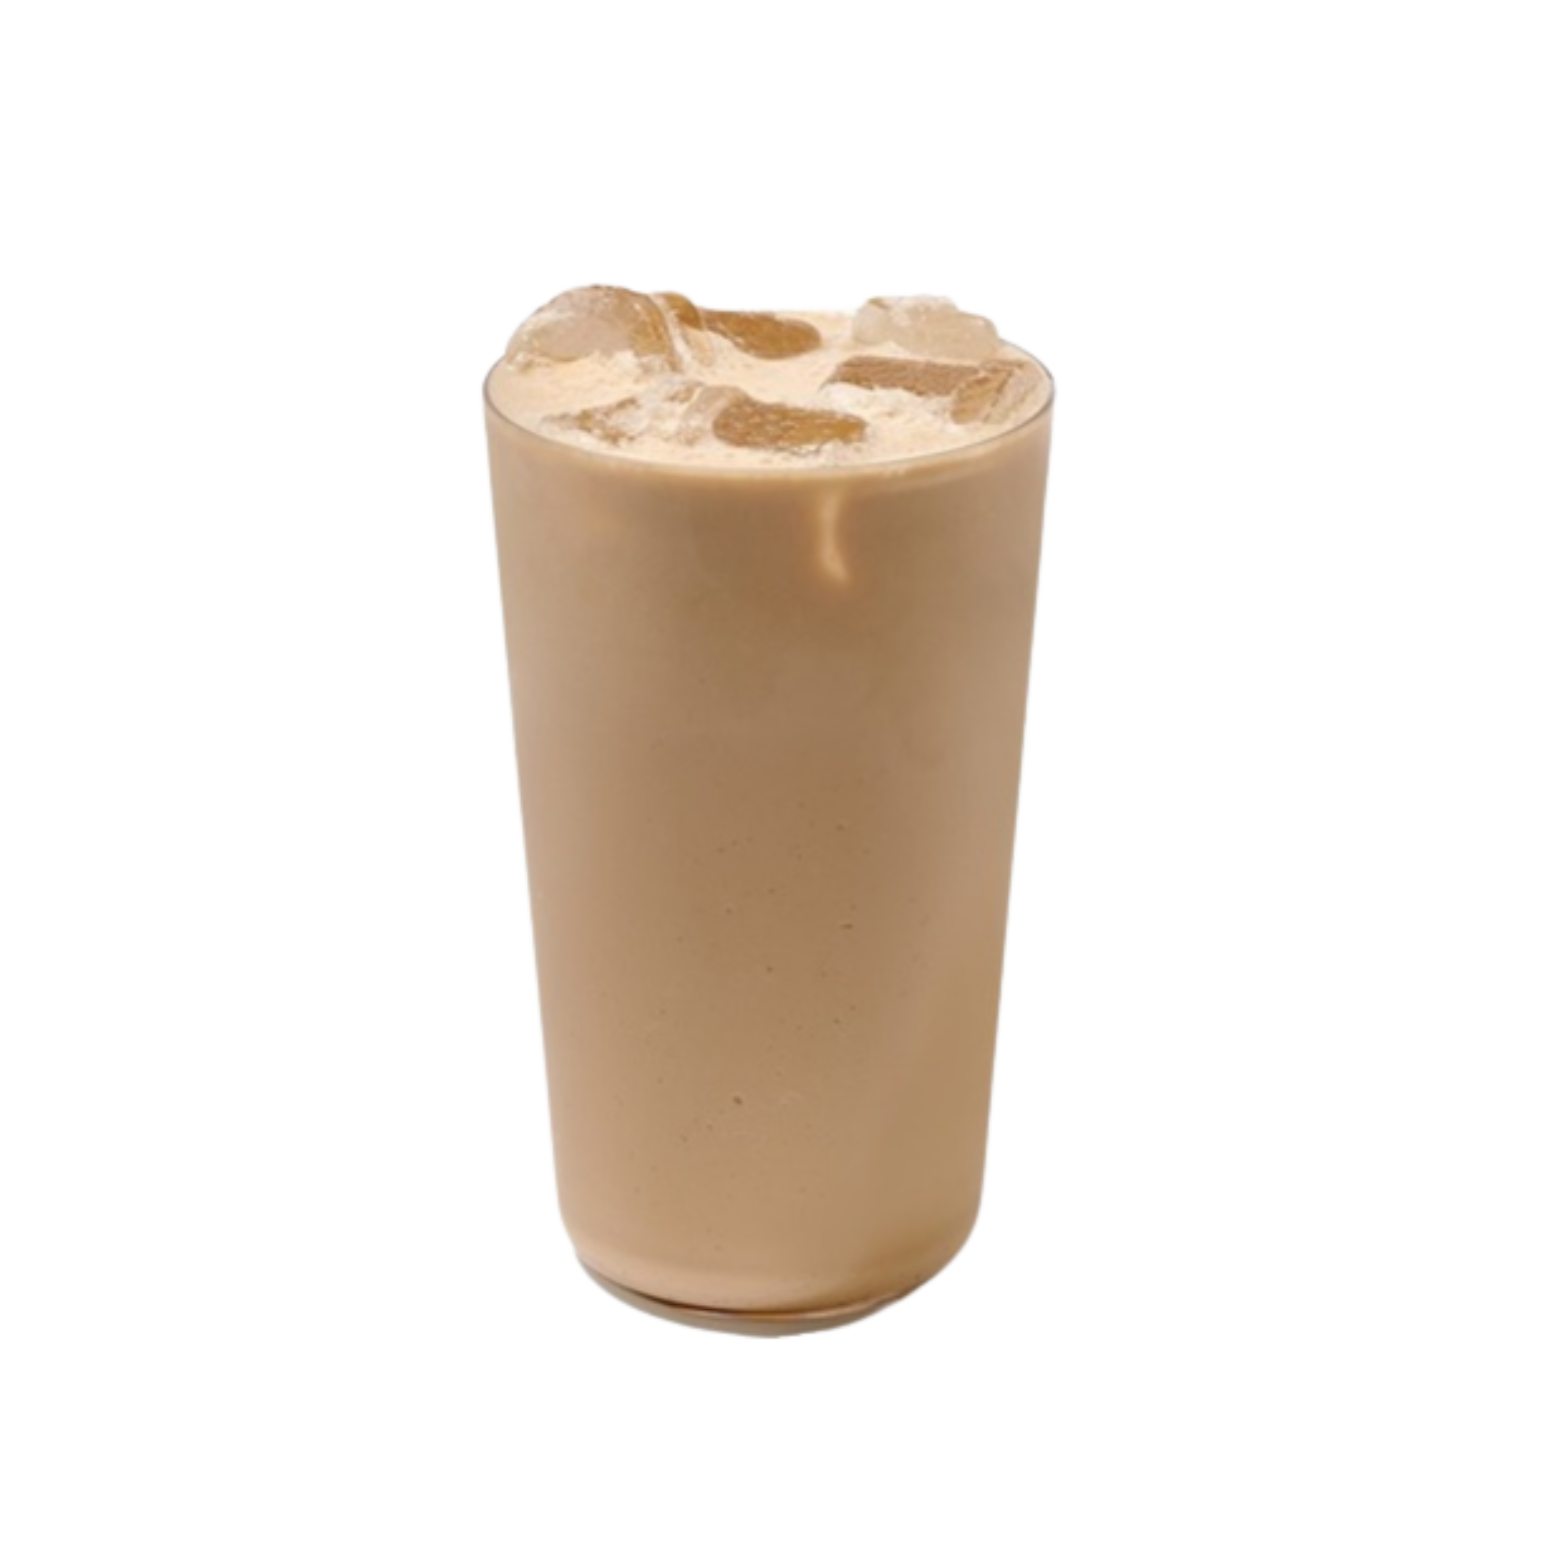

--- Printing Complete ---


In [31]:
import pandas as pd
import requests
import cv2
from deepface import DeepFace
import numpy as np
import datetime
import random
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import traceback
import os
from IPython.display import Image, display # Crucial for displaying images in notebooks

# ----------------------------
# Helper Functions for File Paths
# ----------------------------
def get_sanitized_name(name):
    """
    Converts a human-readable product name for drinks into a filename-safe string.
    Replaces spaces and hyphens with single underscores.
    """
    # Replace all spaces and hyphens with a single underscore
    sanitized_name = name.replace(' ', '_').replace('-', '_')
    # Replace any double underscores that might result from the previous step
    while '__' in sanitized_name:
        sanitized_name = sanitized_name.replace('__', '_')
    return sanitized_name

def get_pastry_filename(name):
    """
    Returns the exact pastry name for the file path, as it contains spaces.
    """
    return name

# ----------------------------
# Enhanced Emotion Processing
# ----------------------------
class EmotionProcessor:
    """Compensates for DeepFace limitations with psychological insights"""
    EMOTION_HIERARCHY = {
        'angry': 0.9,     # Highest priority
        'fear': 0.85,
        'sad': 0.8,
        'disgust': 0.75,
        'surprise': 0.7,
        'happy': 0.65,    # Lower priority - people often mask true feelings
        'neutral': 0.5
    }

    EMOTION_GROUPS = {
        'positive': ['happy', 'surprise'],
        'negative': ['angry', 'sad', 'fear', 'disgust'],
        'neutral': ['neutral']
    }

    COMPLEX_EMOTION_RULES = {
        # Sadness + Fear = Anxious (قلق)
        'anxious': lambda emotions: emotions.get('sad', 0) > 20 and emotions.get('fear', 0) > 20,
        # Neutral + low overall scores = Bored (ملل)
        'bored': lambda emotions: emotions.get('neutral', 0) > 50 and sum(emotions.values()) < 70,
        # Happy + Calm = Relaxed (استرخاء)
        'relaxed': lambda emotions: emotions.get('happy', 0) > 30 and emotions.get('calm', 0) > 30,
        # Angry + high overall scores = Stressed (توتر)
        'stressed': lambda emotions: emotions.get('angry', 0) > 30 and sum(emotions.values()) > 80,
    }

    @staticmethod
    def enhance_emotion_detection(raw_emotions):
        """Apply psychological insights to refine emotion detection"""
        # Apply hierarchy weights
        weighted_emotions = {e: s * EmotionProcessor.EMOTION_HIERARCHY.get(e, 0.5)
                             for e, s in raw_emotions.items()}

        # Normalize
        total = sum(weighted_emotions.values())
        if total == 0:
            return raw_emotions

        enhanced = {e: s/total * 100 for e, s in weighted_emotions.items()}

        # Infer complex emotions
        inferred_mood = None
        for mood, rule in EmotionProcessor.COMPLEX_EMOTION_RULES.items():
            if rule(enhanced):
                inferred_mood = mood
                break

        if inferred_mood:
            # Rebalance scores based on inferred mood
            print(f"Inferred complex mood: {inferred_mood}")
            for emotion in enhanced:
                enhanced[emotion] = enhanced.get(emotion, 0) * 0.5  # Reduce other scores
            enhanced[inferred_mood] = 50.0 # Set inferred mood score high

        return enhanced

    @staticmethod
    def get_emotion_group(emotions):
        """Determine dominant emotion group"""
        # Check for complex emotions first
        dominant_emotion = max(emotions, key=emotions.get)
        if dominant_emotion in ['bored', 'anxious', 'relaxed', 'stressed']:
            if dominant_emotion in ['anxious', 'stressed', 'bored']:
                return 'negative'
            elif dominant_emotion == 'relaxed':
                return 'positive'

        # Fallback to basic groups
        group_scores = {g: 0 for g in EmotionProcessor.EMOTION_GROUPS}
        for emotion, score in emotions.items():
            for group, emotions_in_group in EmotionProcessor.EMOTION_GROUPS.items():
                if emotion in emotions_in_group:
                    group_scores[group] += score

        return max(group_scores, key=group_scores.get)

# ----------------------------
# Context Analyzer
# ----------------------------
class ContextAnalyzer:
    """Analyzes contextual factors for recommendations"""
    TIME_CATEGORIES = {
        'morning': (6, 12),
        'afternoon': (12, 18),
        'evening': (18, 22),
        'night': (22, 6)
    }

    SEASON_MONTHS = {
        'winter': [11, 12, 1, 2],
        'spring': [3, 4, 5],
        'summer': [6, 7, 8],
        'fall': [9, 10]
    }

    @staticmethod
    def analyze_context():
        """Analyze current context"""
        now = datetime.now()
        current_hour = now.hour
        current_month = now.month

        # Determine time category
        time_category = 'night'
        for cat, (start, end) in ContextAnalyzer.TIME_CATEGORIES.items():
            if end > start:
                if start <= current_hour < end:
                    time_category = cat
            else:  # Overnight
                if current_hour >= start or current_hour < end:
                    time_category = cat

        # Determine season
        season = 'summer'
        for s, months in ContextAnalyzer.SEASON_MONTHS.items():
            if current_month in months:
                season = s

        # Weather
        current_temp = ContextAnalyzer.get_weather()
        weather_condition = 'Hot' if current_temp > 25 else 'Cold'

        return {
            'time_category': time_category,
            'season': season,
            'temperature': current_temp,
            'weather_condition': weather_condition,
            'weekend': now.weekday() >= 5  # Saturday or Sunday
        }

    @staticmethod
    def get_weather():
        """Get current weather"""
        API_KEY = "25f3e394030d70a368078f14d89ecee2"
        CITY = "Jeddah"

        url = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"
        try:
            response = requests.get(url, timeout=3)
            data = response.json()
            if response.status_code == 200 and "main" in data:
                return data["main"]["temp"]
        except:
            return 28  # Default temperature

# ----------------------------
# Recommendation Engine
# ----------------------------
class RecommendationEngine:
    """Advanced drink recommendation system"""
    def __init__(self, df_drinks, df_pastries, df_mood_prefs):
        self.df_drinks = df_drinks
        self.df_pastries = df_pastries
        self.last_recommendations = []
        self.diversity_factor = 0.25

        # Create mood preference vectors
        self.mood_trait_vectors = {}
        for _, row in df_mood_prefs.iterrows():
            vector = []
            for trait in ['acidity', 'aroma', 'bitterness', 'sweetness', 'body']:
                # Create consistent hash values for traits
                trait_value = row[f'{trait}_preference']
                vector.append(hash(trait_value) % 100)
            self.mood_trait_vectors[row['mood']] = vector

    def recommend_drink(self, mood_profile, customer_age, context):
        """Generate drink recommendation with advanced logic"""
        # Enhanced emotion processing
        enhanced_emotions = EmotionProcessor.enhance_emotion_detection(mood_profile)
        emotion_group = EmotionProcessor.get_emotion_group(enhanced_emotions)

        print(f"\n--- Context Analysis ---")
        print(f"    Enhanced Mood: {enhanced_emotions}")
        print(f"    Emotion Group: {emotion_group}")
        print(f"    Age: {customer_age} years")
        print(f"    Time: {context['time_category']}")
        print(f"    Season: {context['season']}")
        print(f"    Weather: {context['weather_condition']} ({context['temperature']}°C)")
        print(f"    Weekend: {context['weekend']}")

        # Create working copy
        df_scored = self.df_drinks.copy()

        # 1. Mood Matching (Advanced)
        df_scored['mood_score'] = df_scored.apply(
            lambda row: self.calculate_mood_score(row, enhanced_emotions, emotion_group),
            axis=1
        )

        # 2. Contextual Matching
        df_scored['context_score'] = df_scored.apply(
            lambda row: self.calculate_context_score(row, context, customer_age),
            axis=1
        )

        # 3. Business Factors
        max_profit = df_scored['profit_margine'].max()
        df_scored['profit_score'] = df_scored['profit_margine'] / max_profit

        # 4. Diversity Control
        df_scored['diversity_penalty'] = df_scored['product_id'].apply(
            lambda x: 0.7 if x in self.last_recommendations[-3:] else 1.0
        )

        # 5. Final Score
        df_scored['final_score'] = (
            (df_scored['mood_score'] * 0.5) +
            (df_scored['context_score'] * 0.3) +
            (df_scored['profit_score'] * 0.2)
        ) * df_scored['diversity_penalty']

        # Add randomness for diversity
        df_scored['final_score'] *= (1 + self.diversity_factor * (np.random.rand(len(df_scored)) - 0.5))

        # Sort and select
        df_sorted = df_scored.sort_values('final_score', ascending=False)

        # Print top recommendations
        print("\n--- Top Recommendations ---")
        print(df_sorted[['product_name', 'mood_score', 'context_score', 'profit_score', 'final_score']].head(5))

        # Select from top 3
        top_3 = df_sorted.head(3)
        recommended = top_3.sample(1)
        drink_id = recommended['product_id'].values[0]

        # Update recommendation history
        self.last_recommendations.append(drink_id)
        if len(self.last_recommendations) > 10:
            self.last_recommendations.pop(0)

        # Pastry recommendation
        pastry_rec = self.recommend_pastry(recommended, emotion_group)

        return recommended, pastry_rec

    def calculate_mood_score(self, drink, emotions, emotion_group):
        """Calculate mood compatibility score"""
        # 1. Trait matching with mood preferences
        mood_similarity = 0
        for mood, score in emotions.items():
            # Changed condition from 'score > 10' to 'score > 0.5' for better sensitivity
            if mood in self.mood_trait_vectors and score > 0.5:
                # Create consistent hash values for drink traits
                drink_vector = [hash(str(drink[t])) % 100 for t in ['acidity', 'aroma', 'bitterness', 'sweetness', 'body']]
                similarity = cosine_similarity([self.mood_trait_vectors[mood]], [drink_vector])[0][0]
                mood_similarity += similarity * (score / 100)

        # 2. Emotion group specific boosters
        group_boost = 0
        if emotion_group == 'negative':
            if 'comfort' in drink['mood_tags']:
                group_boost += 1.5
            if drink['sweetness'] in ['high', 'medium']:
                group_boost += 1.0
        elif emotion_group == 'positive':
            # Positive emotions get boost from balanced profiles
            if 'balanced' in drink['mood_tags']:
                group_boost += 1.2
        else:  # neutral
            if 'balanced' in drink['mood_tags']:
                group_boost += 1.0

        # 3. Dominant emotion specific rules
        dominant_emotion = max(emotions, key=emotions.get)
        emotion_rules = {
            'sad': {'bitterness': ['low'], 'sweetness': ['high', 'medium']},
            'angry': {'aroma': ['strong'], 'body': ['full']},
            'happy': {'sweetness': ['medium'], 'body': ['medium']},
            'fear': {'body': ['light']},
            'bored': {'aroma': ['strong'], 'sweetness': ['high']},
            'anxious': {'body': ['light'], 'aroma': ['faint']},
            'relaxed': {'aroma': ['balanced'], 'sweetness': ['mild']},
            'stressed': {'bitterness': ['strong'], 'body': ['full']}
        }

        emotion_match = 0
        if dominant_emotion in emotion_rules:
            for trait, values in emotion_rules[dominant_emotion].items():
                if trait in drink and drink[trait] in values:
                    emotion_match += 1.0

        return mood_similarity + group_boost + emotion_match

    def calculate_context_score(self, drink, context, age):
        """Calculate context compatibility score"""
        score = 1.0

        # Time of day scoring (removed caffeine references)
        time_rules = {
            'morning': {'aroma': 'strong', 'body': 'full'},
            'afternoon': {'hot_or_cold': 'Cold', 'body': 'medium'},
            'evening': {'body': 'light'},
            'night': {'body': 'light'}
        }

        time_cat = context['time_category']
        if time_cat in time_rules:
            for trait, value in time_rules[time_cat].items():
                if trait in drink and drink[trait] == value:
                    score += 0.8

        # Weather scoring
        if context['weather_condition'] == 'Hot':
            if 'hot_or_cold' in drink and drink['hot_or_cold'] == 'Cold':
                score += 1.0
        else:
            if 'hot_or_cold' in drink and drink['hot_or_cold'] == 'Hot':
                score += 1.0

        # Seasonal adjustments
        if 'hot_or_cold' in drink:
            if context['season'] == 'winter' and drink['hot_or_cold'] == 'Hot':
                score += 0.5
            elif context['season'] == 'summer' and drink['hot_or_cold'] == 'Cold':
                score += 0.5

        # Weekend scoring
        if context['weekend']:
            if 'mood_tags' in drink and 'indulgent' in drink['mood_tags']:
                score += 0.7
        else:  # Weekday
            if 'mood_tags' in drink and 'energizing' in drink['mood_tags']:
                score += 0.5

        # Age scoring (simplified without caffeine)
        if age < 18:
            if 'main_catagory' in drink and drink['main_catagory'] == 'Decaf_Beverages':
                score += 2.0  # Big boost for decaf for kids
            elif 'sweetness' in drink and drink['sweetness'] in ['high', 'medium']:
                score += 1.0 # Boost for sweet things
            else:
                score *= 0.1 # Penalize other types of drinks

        return score

    def recommend_pastry(self, drink, emotion_group):
        """Recommend pastry based on drink and mood, with mood-based probability"""
        if self.df_pastries.empty:
            return ""

        # Probability for pastry recommendation based on emotion group
        pastry_probability = 0.7 if emotion_group == 'negative' else 0.3

        if random.random() > pastry_probability:
            return ""

        df_scored = self.df_pastries.copy()

        # Create pairing scores
        drink_name = drink['product_name'].values[0]
        sweetness = drink['sweetness'].values[0] if 'sweetness' in drink else 'medium'
        bitterness = drink['bitterness'].values[0] if 'bitterness' in drink else 'medium'

        # Complementary pairing logic
        if bitterness in ['high', 'medium']:
            df_scored['pairing_score'] = df_scored['Product_Name'].apply(
                lambda x: 3.0 if 'Chocolate' in str(x) else 2.0 if 'Caramel' in str(x) else 1.0
            )
        elif sweetness in ['high', 'medium']:
            df_scored['pairing_score'] = df_scored['Product_Name'].apply(
                lambda x: 2.5 if any(w in str(x) for w in ['Croissant', 'Bread']) else 1.0
            )
        else:
            df_scored['pairing_score'] = 1.0

        # Mood-based scoring
        if emotion_group == 'negative':
            df_scored['mood_score'] = df_scored['Product_Name'].apply(
                lambda x: 3.0 if any(w in str(x) for w in ['Chocolate', 'Brownie', 'Cheesecake']) else 1.0
            )
        else:
            df_scored['mood_score'] = 1.0

        # Final score
        df_scored['final_score'] = df_scored['pairing_score'] * df_scored['mood_score'] * np.random.rand(len(df_scored))
        top_pastry = df_scored.nlargest(1, 'final_score')

        if not top_pastry.empty:
            return top_pastry['Product_Name'].values[0]
        else:
            return ""

# ----------------------------
# Data Loading Function
# ----------------------------
def load_data():
    """Load all required data files"""
    df_profit, df_catalog, df_traits, df_mood_prefs = None, None, None, None
    df_pastries = pd.DataFrame() # Default to empty dataframe

    try:
        df_profit = pd.read_csv('profit_margin.csv')
        df_catalog = pd.read_csv('product_catalog.csv')
        df_traits = pd.read_csv('coffee_traits.csv')
        df_mood_prefs = pd.read_csv('mood_preferences.csv')
        print("Successfully loaded core data files.")
    except Exception as e:
        print(f"Error loading a core data file: {e}")
        return None, None, None, None

    try:
        df_pastries = pd.read_csv('pastries.csv')
        df_pastries.columns = df_pastries.columns.str.strip()
        df_pastries['Product_Name'] = df_pastries['Product_Name'].astype(str)
        print("Successfully loaded pastries data.")
    except FileNotFoundError:
        print("pastries.csv not found. Continuing without pastry recommendations.")
    except Exception as e:
        print(f"Error loading pastries.csv: {e}")
        print("Continuing without pastry recommendations.")

    # Clean column names
    for df in [df_profit, df_catalog, df_traits, df_mood_prefs]:
        df.columns = df.columns.str.strip()

    # Clean product catalog - remove empty rows
    df_catalog = df_catalog.dropna(subset=['product_id'])
    df_catalog = df_catalog[df_catalog['product_id'].notna()]

    # "Spanish Latte" inconsistency
    # The 'product_name' column should contain the human-readable name,
    # which is used for display. The code will handle converting this to a
    # filename path.
    df_catalog.loc[df_catalog['product_name'] == 'Spanish_Latte', 'product_name'] = 'Spanish Latte'

    # Drop duplicate column in traits if it exists
    if 'hot_or_cold' in df_traits.columns:
        df_traits = df_traits.drop('hot_or_cold', axis=1)

    # Add dummy 'caffeine_level' column if it's missing to prevent crash
    if 'caffeine_level' not in df_traits.columns:
        df_traits['caffeine_level'] = 'medium'
        print("Warning: 'caffeine_level' column not found. Adding a default 'medium' level.")

    # Merge datasets
    df_merged = pd.merge(df_catalog, df_traits, on='product_id')
    df_drinks = pd.merge(df_merged, df_profit, on='product_id')

    # Convert calories to numeric and fill missing values
    if 'calories' in df_drinks:
        df_drinks['calories'] = pd.to_numeric(df_drinks['calories'], errors='coerce')
    else:
        df_drinks['calories'] = 200  # Default column

    df_drinks['calories'] = df_drinks['calories'].fillna(200)

    # Add psychological tags
    df_drinks['mood_tags'] = df_drinks.apply(
        lambda row: [
            'comfort' if row['sweetness'] in ['high', 'medium'] else '',
            'energizing' if row['caffeine_level'] == 'high' else '',
            'relaxing' if row['caffeine_level'] == 'low' else '',
            'indulgent' if 'calories' in row and row['calories'] > 200 else ''
        ], axis=1
    )

    print("Successfully merged all drink data.")
    print(f"Loaded {len(df_drinks)} drinks")

    return df_drinks, df_pastries, df_mood_prefs

# ----------------------------
# Print Functionality
# ----------------------------
def print_final_order(file_path, item_name):
    """Simulates printing a single image and displays it in a notebook."""
    # Standardize the path to use forward slashes for cross-platform compatibility
    normalized_path = file_path.replace('\\', '/')
    if not os.path.exists(normalized_path):
        print(f"Error: The image file '{normalized_path}' does not exist. Cannot print.")
        return

    print(f"Printing image: {normalized_path} with order name: {item_name}")
    
    # Add this line to display the image
    display(Image(filename=normalized_path))

    print("--- Printing Complete ---")


# ----------------------------
# Main Execution
# ----------------------------
def main():
    # Load data
    df_drinks, df_pastries, df_mood_prefs = load_data()

    # Exit if data loading failed
    if df_drinks is None or df_mood_prefs is None:
        print("Exiting due to data loading errors")
        return

    # Analyze context
    context = ContextAnalyzer.analyze_context()

    # Initialize engine
    engine = RecommendationEngine(df_drinks, df_pastries, df_mood_prefs)

    print("\nWelcome to the Emotional Barista™ System")
    print("Choose interaction method:")
    print("1 - Camera (real-time analysis)")
    print("2 - Static image")
    print("3 - Manual emotion input")
    print("q - Exit")

    choice = input("Enter option: ")

    if choice == '1':
        # Camera mode
        print("\nStarting camera. Press 'r' to capture, 'q' to quit.")
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Error: Camera not accessible")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            cv2.imshow('Emotional Barista™', frame)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('r'):
                try:
                    # Analyze face
                    results = DeepFace.analyze(frame, actions=['emotion', 'age'],
                                             enforce_detection=False, silent=True)
                    if not results:
                        raise ValueError("No face detected")
                    result = results[0]

                    # Process emotions
                    raw_emotions = result['emotion']
                    age = result['age']
                    enhanced_emotions = EmotionProcessor.enhance_emotion_detection(raw_emotions)

                    print(f"\nEmotion Analysis:")
                    for e, s in enhanced_emotions.items():
                        print(f"  {e.capitalize()}: {s:.1f}%")

                    # Get recommendation
                    drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)

                    # Get the product name for display
                    drink_name = drink_rec['product_name'].values[0]

                    # Get the hot_or_cold value for the folder path
                    hot_or_cold = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "hot"
                    drink_type_folder = f"{hot_or_cold.lower()}_drinks"

                    # Sanitize the drink name for the filename
                    sanitized_drink_name = get_sanitized_name(drink_name)

                    if 'main_catagory' in drink_rec:
                        drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
                    else:
                        drink_type = "Regular"

                    temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"

                    output = (f"\n--- Your Emotional Barista Recommendation ---"
                              f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                              f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                              f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                              f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")

                    if pastry_rec:
                        output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"

                    print(output)

                    # --- New Printing Logic ---
                    # Use the hot_or_cold column to determine the subfolder
                    drink_image_path = os.path.join("static/barns_food_and_drink", drink_type_folder, f"{sanitized_drink_name}.png")
                    print_final_order(drink_image_path, drink_name)

                    # Use the raw name for the pastry
                    if pastry_rec:
                        pastry_image_path = os.path.join("static/barns_food_and_drink", "pastries", f"{pastry_rec}.png")
                        print_final_order(pastry_image_path, pastry_rec)

                except Exception as e:
                    print(f"Analysis error: {e}. Using fallback.")
                    print(traceback.format_exc())
                    fallback_emotions = {'neutral': 100}
                    # Assign both returned values
                    drink_rec, pastry_rec = engine.recommend_drink(fallback_emotions, 30, context)
                    # To fix the printing issue, replace underscores with spaces for the filename
                    drink_name = drink_rec['product_name'].values[0]
                    print(f"\nRecommended Drink: {drink_name}")
                    if pastry_rec:
                        print(f"Recommended Pastry: {pastry_rec}")

            elif key == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

    elif choice == '2':
        # Static image mode
        path = input("Enter image path: ")
        try:
            img = cv2.imread(path)
            if img is None:
                raise ValueError("Image not found")

            # Analyze face
            results = DeepFace.analyze(img, actions=['emotion', 'age'],
                                     enforce_detection=False, silent=True)
            if not results:
                raise ValueError("No face detected")
            result = results[0]

            # Process emotions
            raw_emotions = result['emotion']
            age = result['age']
            enhanced_emotions = EmotionProcessor.enhance_emotion_detection(raw_emotions)

            print("\nEmotion Analysis:")
            for e, s in enhanced_emotions.items():
                print(f"  {e.capitalize()}: {s:.1f}%")

            # Get recommendation
            drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)

            # Get the product name for display
            drink_name = drink_rec['product_name'].values[0]

            # Get the hot_or_cold value for the folder path
            hot_or_cold = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "hot"
            drink_type_folder = f"{hot_or_cold.lower()}_drinks"

            # Sanitize the drink name for the filename
            sanitized_drink_name = get_sanitized_name(drink_name)

            if 'main_catagory' in drink_rec:
                drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
            else:
                drink_type = "Regular"

            temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"

            output = (f"\n--- Your Emotional Barista Recommendation ---"
                      f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                      f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                      f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                      f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")

            if pastry_rec:
                output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"

            print(output)

            # --- New Printing Logic ---
            # Use the hot_or_cold column to determine the subfolder
            drink_image_path = os.path.join("static/barns_food_and_drink", drink_type_folder, f"{sanitized_drink_name}.png")
            print_final_order(drink_image_path, drink_name)

            # Use the raw name for the pastry
            if pastry_rec:
                pastry_image_path = os.path.join("static/barns_food_and_drink", "pastries", f"{pastry_rec}.png")
                print_final_order(pastry_image_path, pastry_rec)

        except Exception as e:
            print(f"Error: {e}. Using fallback recommendation.")
            print(traceback.format_exc())
            fallback_emotions = {'neutral': 100}
            #  Assign both returned values
            drink_rec, pastry_rec = engine.recommend_drink(fallback_emotions, 30, context)
            # To fix the printing issue, replace underscores with spaces for the filename
            drink_name = drink_rec['product_name'].values[0]
            print(f"\nFallback Recommendation: {drink_name}")
            if pastry_rec:
                print(f"Recommended Pastry: {pastry_rec}")

    elif choice == '3':
        # Manual input mode
        print("\nEnter emotion percentages (sum to 100):")
        emotions = {}
        for e in ['happy', 'sad', 'angry', 'fear', 'disgust', 'surprise', 'neutral']:
            val = float(input(f"{e.capitalize()}: "))
            emotions[e] = val

        age = int(input("Enter age: "))
        enhanced_emotions = EmotionProcessor.enhance_emotion_detection(emotions)
        drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)

        # Get the product name for display
        drink_name = drink_rec['product_name'].values[0]

        # Get the hot_or_cold value for the folder path
        hot_or_cold = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "hot"
        drink_type_folder = f"{hot_or_cold.lower()}_drinks"

        # Sanitize the drink name for the filename
        sanitized_drink_name = get_sanitized_name(drink_name)

        if 'main_catagory' in drink_rec:
            drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
        else:
            drink_type = "Regular"

        temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"

        output = (f"\n--- Your Emotional Barista Recommendation ---"
                  f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                  f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                  f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                  f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")

        if pastry_rec:
            output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"

        print(output)

        # --- New Printing Logic ---
        # Use the hot_or_cold column to determine the subfolder
        drink_image_path = os.path.join("static/barns_food_and_drink", drink_type_folder, f"{sanitized_drink_name}.png")
        print_final_order(drink_image_path, drink_name)

        # Use the raw name for the pastry
        if pastry_rec:
            pastry_image_path = os.path.join("static/barns_food_and_drink", "pastries", f"{pastry_rec}.png")
            print_final_order(pastry_image_path, pastry_rec)

    elif choice == 'q':
        print("Goodbye!")
    else:
        print("Invalid option")

if __name__ == "__main__":
    main()


In [ ]:
import pandas as pd
import requests
import cv2
from deepface import DeepFace
import numpy as np
import datetime
import random
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity
import traceback

# ----------------------------
# Enhanced Emotion Processing
# ----------------------------
class EmotionProcessor:
    """Compensates for DeepFace limitations with psychological insights"""
    EMOTION_HIERARCHY = {
        'angry': 0.9,    # Highest priority
        'fear': 0.85,
        'sad': 0.8,
        'disgust': 0.75,
        'surprise': 0.7,
        'happy': 0.65,   # Lower priority - people often mask true feelings
        'neutral': 0.5
    }
    
    EMOTION_GROUPS = {
        'positive': ['happy', 'surprise'],
        'negative': ['angry', 'sad', 'fear', 'disgust'],
        'neutral': ['neutral']
    }
    
    COMPLEX_EMOTION_RULES = {
        # Sadness + Fear = Anxious (قلق)
        'anxious': lambda emotions: emotions.get('sad', 0) > 20 and emotions.get('fear', 0) > 20,
        # Neutral + low overall scores = Bored (ملل)
        'bored': lambda emotions: emotions.get('neutral', 0) > 50 and sum(emotions.values()) < 70,
        # Happy + Calm = Relaxed (استرخاء)
        'relaxed': lambda emotions: emotions.get('happy', 0) > 30 and emotions.get('calm', 0) > 30,
        # Angry + high overall scores = Stressed (توتر)
        'stressed': lambda emotions: emotions.get('angry', 0) > 30 and sum(emotions.values()) > 80,
    }

    @staticmethod
    def enhance_emotion_detection(raw_emotions):
        """Apply psychological insights to refine emotion detection"""
        # Apply hierarchy weights
        weighted_emotions = {e: s * EmotionProcessor.EMOTION_HIERARCHY.get(e, 0.5)
                             for e, s in raw_emotions.items()}
        
        # Normalize
        total = sum(weighted_emotions.values())
        if total == 0:
            return raw_emotions
        
        enhanced = {e: s/total * 100 for e, s in weighted_emotions.items()}

        # Infer complex emotions
        inferred_mood = None
        for mood, rule in EmotionProcessor.COMPLEX_EMOTION_RULES.items():
            if rule(enhanced):
                inferred_mood = mood
                break
        
        if inferred_mood:
            # Rebalance scores based on inferred mood
            print(f"Inferred complex mood: {inferred_mood}")
            for emotion in enhanced:
                enhanced[emotion] = enhanced.get(emotion, 0) * 0.5  # Reduce other scores
            enhanced[inferred_mood] = 50.0 # Set inferred mood score high
        
        return enhanced
    
    @staticmethod
    def get_emotion_group(emotions):
        """Determine dominant emotion group"""
        # Check for complex emotions first
        dominant_emotion = max(emotions, key=emotions.get)
        if dominant_emotion in ['bored', 'anxious', 'relaxed', 'stressed']:
            if dominant_emotion in ['anxious', 'stressed', 'bored']:
                return 'negative'
            elif dominant_emotion == 'relaxed':
                return 'positive'
        
        # Fallback to basic groups
        group_scores = {g: 0 for g in EmotionProcessor.EMOTION_GROUPS}
        for emotion, score in emotions.items():
            for group, emotions_in_group in EmotionProcessor.EMOTION_GROUPS.items():
                if emotion in emotions_in_group:
                    group_scores[group] += score
        
        return max(group_scores, key=group_scores.get)

# ----------------------------
# Context Analyzer
# ----------------------------
class ContextAnalyzer:
    """Analyzes contextual factors for recommendations"""
    TIME_CATEGORIES = {
        'morning': (6, 12),
        'afternoon': (12, 18),
        'evening': (18, 22),
        'night': (22, 6)
    }
    
    SEASON_MONTHS = {
        'winter': [11, 12, 1, 2],
        'spring': [3, 4, 5],
        'summer': [6, 7, 8],
        'fall': [9, 10]
    }
    
    @staticmethod
    def analyze_context():
        """Analyze current context"""
        now = datetime.now()
        current_hour = now.hour
        current_month = now.month
        
        # Determine time category
        time_category = 'night'
        for cat, (start, end) in ContextAnalyzer.TIME_CATEGORIES.items():
            if end > start:
                if start <= current_hour < end:
                    time_category = cat
            else:  # Overnight
                if current_hour >= start or current_hour < end:
                    time_category = cat
        
        # Determine season
        season = 'summer'
        for s, months in ContextAnalyzer.SEASON_MONTHS.items():
            if current_month in months:
                season = s
        
        # Weather
        current_temp = ContextAnalyzer.get_weather()
        weather_condition = 'Hot' if current_temp > 25 else 'Cold'
        
        return {
            'time_category': time_category,
            'season': season,
            'temperature': current_temp,
            'weather_condition': weather_condition,
            'weekend': now.weekday() >= 5  # Saturday or Sunday
        }
    
    @staticmethod
    def get_weather():
        """Get current weather"""
        API_KEY = "25f3e394030d70a368078f14d89ecee2"
        CITY = "Jeddah"
        
        url = f"http://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"
        try:
            response = requests.get(url, timeout=3)
            data = response.json()
            if response.status_code == 200 and "main" in data:
                return data["main"]["temp"]
        except:
            return 28  # Default temperature

# ----------------------------
# Recommendation Engine
# ----------------------------
class RecommendationEngine:
    """Advanced drink recommendation system"""
    def __init__(self, df_drinks, df_pastries, df_mood_prefs):
        self.df_drinks = df_drinks
        self.df_pastries = df_pastries
        self.last_recommendations = []
        self.diversity_factor = 0.25
        
        # Create mood preference vectors
        self.mood_trait_vectors = {}
        for _, row in df_mood_prefs.iterrows():
            vector = []
            for trait in ['acidity', 'aroma', 'bitterness', 'sweetness', 'body']:
                # Create consistent hash values for traits
                trait_value = row[f'{trait}_preference']
                vector.append(hash(trait_value) % 100)
            self.mood_trait_vectors[row['mood']] = vector
    
    def recommend_drink(self, mood_profile, customer_age, context):
        """Generate drink recommendation with advanced logic"""
        # Enhanced emotion processing
        enhanced_emotions = EmotionProcessor.enhance_emotion_detection(mood_profile)
        emotion_group = EmotionProcessor.get_emotion_group(enhanced_emotions)
        
        print(f"\n--- Context Analysis ---")
        print(f"    Enhanced Mood: {enhanced_emotions}")
        print(f"    Emotion Group: {emotion_group}")
        print(f"    Age: {customer_age} years")
        print(f"    Time: {context['time_category']}")
        print(f"    Season: {context['season']}")
        print(f"    Weather: {context['weather_condition']} ({context['temperature']}°C)")
        print(f"    Weekend: {context['weekend']}")
        
        # Create working copy
        df_scored = self.df_drinks.copy()
        
        # 1. Mood Matching (Advanced)
        df_scored['mood_score'] = df_scored.apply(
            lambda row: self.calculate_mood_score(row, enhanced_emotions, emotion_group),
            axis=1
        )
        
        # 2. Contextual Matching
        df_scored['context_score'] = df_scored.apply(
            lambda row: self.calculate_context_score(row, context, customer_age),
            axis=1
        )
        
        # 3. Business Factors
        max_profit = df_scored['profit_margine'].max()
        df_scored['profit_score'] = df_scored['profit_margine'] / max_profit
        
        # 4. Diversity Control
        df_scored['diversity_penalty'] = df_scored['product_id'].apply(
            lambda x: 0.7 if x in self.last_recommendations[-3:] else 1.0
        )
        
        # 5. Final Score
        df_scored['final_score'] = (
            (df_scored['mood_score'] * 0.5) +
            (df_scored['context_score'] * 0.3) +
            (df_scored['profit_score'] * 0.2)
        ) * df_scored['diversity_penalty']
        
        # Add randomness for diversity
        df_scored['final_score'] *= (1 + self.diversity_factor * (np.random.rand(len(df_scored)) - 0.5))
        
        # Sort and select
        df_sorted = df_scored.sort_values('final_score', ascending=False)
        
        # Print top recommendations
        print("\n--- Top Recommendations ---")
        print(df_sorted[['product_name', 'mood_score', 'context_score', 'profit_score', 'final_score']].head(5))
        
        # Select from top 3
        top_3 = df_sorted.head(3)
        recommended = top_3.sample(1)
        drink_id = recommended['product_id'].values[0]
        
        # Update recommendation history
        self.last_recommendations.append(drink_id)
        if len(self.last_recommendations) > 10:
            self.last_recommendations.pop(0)
        
        # Pastry recommendation
        pastry_rec = self.recommend_pastry(recommended, emotion_group)
        
        return recommended, pastry_rec
    
    def calculate_mood_score(self, drink, emotions, emotion_group):
        """Calculate mood compatibility score"""
        # 1. Trait matching with mood preferences
        mood_similarity = 0
        for mood, score in emotions.items():
            # Changed condition from 'score > 10' to 'score > 0.5' for better sensitivity
            if mood in self.mood_trait_vectors and score > 0.5:
                # Create consistent hash values for drink traits
                drink_vector = [hash(str(drink[t])) % 100 for t in ['acidity', 'aroma', 'bitterness', 'sweetness', 'body']]
                similarity = cosine_similarity([self.mood_trait_vectors[mood]], [drink_vector])[0][0]
                mood_similarity += similarity * (score / 100)
        
        # 2. Emotion group specific boosters
        group_boost = 0
        if emotion_group == 'negative':
            if 'comfort' in drink['mood_tags']:
                group_boost += 1.5
            if drink['sweetness'] in ['high', 'medium']:
                group_boost += 1.0
        elif emotion_group == 'positive':
            # Positive emotions get boost from balanced profiles
            if 'balanced' in drink['mood_tags']:
                group_boost += 1.2
        else:  # neutral
            if 'balanced' in drink['mood_tags']:
                group_boost += 1.0
        
        # 3. Dominant emotion specific rules
        dominant_emotion = max(emotions, key=emotions.get)
        emotion_rules = {
            'sad': {'bitterness': ['low'], 'sweetness': ['high', 'medium']},
            'angry': {'aroma': ['strong'], 'body': ['full']},
            'happy': {'sweetness': ['medium'], 'body': ['medium']},
            'fear': {'body': ['light']},
            'bored': {'aroma': ['strong'], 'sweetness': ['high']},
            'anxious': {'body': ['light'], 'aroma': ['faint']},
            'relaxed': {'aroma': ['balanced'], 'sweetness': ['mild']},
            'stressed': {'bitterness': ['strong'], 'body': ['full']}
        }
        
        emotion_match = 0
        if dominant_emotion in emotion_rules:
            for trait, values in emotion_rules[dominant_emotion].items():
                if trait in drink and drink[trait] in values:
                    emotion_match += 1.0
        
        return mood_similarity + group_boost + emotion_match
    
    def calculate_context_score(self, drink, context, age):
        """Calculate context compatibility score"""
        score = 1.0
        
        # Time of day scoring (removed caffeine references)
        time_rules = {
            'morning': {'aroma': 'strong', 'body': 'full'},
            'afternoon': {'hot_or_cold': 'Cold', 'body': 'medium'},
            'evening': {'body': 'light'},
            'night': {'body': 'light'}
        }
        
        time_cat = context['time_category']
        if time_cat in time_rules:
            for trait, value in time_rules[time_cat].items():
                if trait in drink and drink[trait] == value:
                    score += 0.8
        
        # Weather scoring
        if context['weather_condition'] == 'Hot':
            if 'hot_or_cold' in drink and drink['hot_or_cold'] == 'Cold':
                score += 1.0
        else:
            if 'hot_or_cold' in drink and drink['hot_or_cold'] == 'Hot':
                score += 1.0
                
        # Seasonal adjustments
        if 'hot_or_cold' in drink:
            if context['season'] == 'winter' and drink['hot_or_cold'] == 'Hot':
                score += 0.5
            elif context['season'] == 'summer' and drink['hot_or_cold'] == 'Cold':
                score += 0.5
            
        # Weekend scoring
        if context['weekend']:
            if 'mood_tags' in drink and 'indulgent' in drink['mood_tags']:
                score += 0.7
        else:  # Weekday
            if 'mood_tags' in drink and 'energizing' in drink['mood_tags']:
                score += 0.5
                
        # Age scoring (simplified without caffeine)
        if age < 18:
            if 'main_catagory' in drink and drink['main_catagory'] == 'Decaf_Beverages':
                score += 2.0  # Big boost for decaf for kids
            elif 'sweetness' in drink and drink['sweetness'] in ['high', 'medium']:
                score += 1.0 # Boost for sweet things
            else:
                score *= 0.1 # Penalize other types of drinks
                
        return score
    
    def recommend_pastry(self, drink, emotion_group):
        """Recommend pastry based on drink and mood, with mood-based probability"""
        if self.df_pastries.empty:
            return ""
            
        # Probability for pastry recommendation based on emotion group
        pastry_probability = 0.7 if emotion_group == 'negative' else 0.3
        
        if random.random() > pastry_probability:
            return ""
        
        df_scored = self.df_pastries.copy()
        
        # Create pairing scores
        drink_name = drink['product_name'].values[0]
        sweetness = drink['sweetness'].values[0] if 'sweetness' in drink else 'medium'
        bitterness = drink['bitterness'].values[0] if 'bitterness' in drink else 'medium'
        
        # Complementary pairing logic
        if bitterness in ['high', 'medium']:
            df_scored['pairing_score'] = df_scored['Product_Name'].apply(
                lambda x: 3.0 if 'Chocolate' in str(x) else 2.0 if 'Caramel' in str(x) else 1.0
            )
        elif sweetness in ['high', 'medium']:
            df_scored['pairing_score'] = df_scored['Product_Name'].apply(
                lambda x: 2.5 if any(w in str(x) for w in ['Croissant', 'Bread']) else 1.0
            )
        else:
            df_scored['pairing_score'] = 1.0
            
        # Mood-based scoring
        if emotion_group == 'negative':
            df_scored['mood_score'] = df_scored['Product_Name'].apply(
                lambda x: 3.0 if any(w in str(x) for w in ['Chocolate', 'Brownie', 'Cheesecake']) else 1.0
            )
        else:
            df_scored['mood_score'] = 1.0
            
        # Final score
        df_scored['final_score'] = df_scored['pairing_score'] * df_scored['mood_score'] * np.random.rand(len(df_scored))
        top_pastry = df_scored.nlargest(1, 'final_score')
        
        if not top_pastry.empty:
            return top_pastry['Product_Name'].values[0]
        else:
            return ""

# ----------------------------
# Data Loading Function
# ----------------------------
def load_data():
    """Load all required data files"""
    df_profit, df_catalog, df_traits, df_mood_prefs = None, None, None, None
    df_pastries = pd.DataFrame() # Default to empty dataframe

    try:
        df_profit = pd.read_csv('profit_margin.csv')
        df_catalog = pd.read_csv('product_catalog.csv')
        df_traits = pd.read_csv('coffee_traits.csv')
        df_mood_prefs = pd.read_csv('mood_preferences.csv')
        print("Successfully loaded core data files.")
    except Exception as e:
        print(f"Error loading a core data file: {e}")
        return None, None, None, None

    try:
        df_pastries = pd.read_csv('pastries.csv')
        df_pastries.columns = df_pastries.columns.str.strip()
        df_pastries['Product_Name'] = df_pastries['Product_Name'].astype(str)
        print("Successfully loaded pastries data.")
    except FileNotFoundError:
        print("pastries.csv not found. Continuing without pastry recommendations.")
    except Exception as e:
        print(f"Error loading pastries.csv: {e}")
        print("Continuing without pastry recommendations.")
    
    # Clean column names
    for df in [df_profit, df_catalog, df_traits, df_mood_prefs]:
        df.columns = df.columns.str.strip()
    
    # Clean product catalog - remove empty rows
    df_catalog = df_catalog.dropna(subset=['product_id'])
    df_catalog = df_catalog[df_catalog['product_id'].notna()]
    
    # "Spanish Latte" inconsistency
    df_catalog.loc[df_catalog['product_name'] == 'Spanish Latte', 'product_name'] = 'Spanish_Latte'
    
    # Drop duplicate column in traits if it exists
    if 'hot_or_cold' in df_traits.columns:
        df_traits = df_traits.drop('hot_or_cold', axis=1)

    # Add dummy 'caffeine_level' column if it's missing to prevent crash
    if 'caffeine_level' not in df_traits.columns:
        df_traits['caffeine_level'] = 'medium'
        print("Warning: 'caffeine_level' column not found. Adding a default 'medium' level.")
    
    # Merge datasets
    df_merged = pd.merge(df_catalog, df_traits, on='product_id')
    df_drinks = pd.merge(df_merged, df_profit, on='product_id')
    
    # Convert calories to numeric and fill missing values
    if 'calories' in df_drinks:
        df_drinks['calories'] = pd.to_numeric(df_drinks['calories'], errors='coerce')
    else:
        df_drinks['calories'] = 200  # Default column
    
    df_drinks['calories'] = df_drinks['calories'].fillna(200)
    
    # Add psychological tags
    df_drinks['mood_tags'] = df_drinks.apply(
        lambda row: [
            'comfort' if row['sweetness'] in ['high', 'medium'] else '',
            'energizing' if row['caffeine_level'] == 'high' else '',
            'relaxing' if row['caffeine_level'] == 'low' else '',
            'indulgent' if 'calories' in row and row['calories'] > 200 else ''
        ], axis=1
    )

    print("Successfully merged all drink data.")
    print(f"Loaded {len(df_drinks)} drinks")
    
    return df_drinks, df_pastries, df_mood_prefs

# ----------------------------
# Main Execution
# ----------------------------
def main():
    # Load data
    df_drinks, df_pastries, df_mood_prefs = load_data()
    
    # Exit if data loading failed
    if df_drinks is None or df_mood_prefs is None:
        print("Exiting due to data loading errors")
        return
    
    # Analyze context
    context = ContextAnalyzer.analyze_context()
    
    # Initialize engine
    engine = RecommendationEngine(df_drinks, df_pastries, df_mood_prefs)
    
    print("\nWelcome to the Emotional Barista™ System")
    print("Choose interaction method:")
    print("1 - Camera (real-time analysis)")
    print("2 - Static image")
    print("3 - Manual emotion input")
    print("q - Exit")
    
    choice = input("Enter option: ")
    
    if choice == '1':
        # Camera mode
        print("\nStarting camera. Press 'r' to capture, 'q' to quit.")
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Error: Camera not accessible")
            return
            
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            cv2.imshow('Emotional Barista™', frame)
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('r'):
                try:
                    # Analyze face
                    results = DeepFace.analyze(frame, actions=['emotion', 'age'],
                                             enforce_detection=False, silent=True)
                    if not results:
                        raise ValueError("No face detected")
                    result = results[0]
                    
                    # Process emotions
                    raw_emotions = result['emotion']
                    age = result['age']
                    enhanced_emotions = EmotionProcessor.enhance_emotion_detection(raw_emotions)
                    
                    print(f"\nEmotion Analysis:")
                    for e, s in enhanced_emotions.items():
                        print(f"  {e.capitalize()}: {s:.1f}%")
                    
                    # Get recommendation
                    drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)
                    
                    # Format output
                    drink_name = drink_rec['product_name'].values[0]
                    
                    if 'main_catagory' in drink_rec:
                        drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
                    else:
                        drink_type = "Regular"
                    
                    temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"
                    
                    output = (f"\n--- Your Emotional Barista Recommendation ---"
                              f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                              f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                              f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                              f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")
                    
                    if pastry_rec:
                        output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"
                    
                    print(output)
                    
                except Exception as e:
                    print(f"Analysis error: {e}. Using fallback.")
                    print(traceback.format_exc())
                    fallback_emotions = {'neutral': 100}
                    # Assign both returned values
                    drink_rec, pastry_rec = engine.recommend_drink(fallback_emotions, 30, context)
                    print(f"\nRecommended Drink: {drink_rec['product_name'].values[0]}")
                    if pastry_rec:
                        print(f"Recommended Pastry: {pastry_rec}")
                    
            elif key == ord('q'):
                break
                
        cap.release()
        cv2.destroyAllWindows()
        
    elif choice == '2':
        # Static image mode
        path = input("Enter image path: ")
        try:
            img = cv2.imread(path)
            if img is None:
                raise ValueError("Image not found")
                
            # Analyze face
            results = DeepFace.analyze(img, actions=['emotion', 'age'],
                                     enforce_detection=False, silent=True)
            if not results:
                raise ValueError("No face detected")
            result = results[0]
            
            # Process emotions
            raw_emotions = result['emotion']
            age = result['age']
            enhanced_emotions = EmotionProcessor.enhance_emotion_detection(raw_emotions)
            
            print("\nEmotion Analysis:")
            for e, s in enhanced_emotions.items():
                print(f"  {e.capitalize()}: {s:.1f}%")
            
            # Get recommendation
            drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)
            
            # Format output (Same as camera mode)
            drink_name = drink_rec['product_name'].values[0]
            
            if 'main_catagory' in drink_rec:
                drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
            else:
                drink_type = "Regular"
            
            temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"
            
            output = (f"\n--- Your Emotional Barista Recommendation ---"
                      f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                      f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                      f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                      f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")
            
            if pastry_rec:
                output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"
            
            print(output)
            
        except Exception as e:
            print(f"Error: {e}. Using fallback recommendation.")
            print(traceback.format_exc())
            fallback_emotions = {'neutral': 100}
            #  Assign both returned values
            drink_rec, pastry_rec = engine.recommend_drink(fallback_emotions, 30, context)
            print(f"\nFallback Recommendation: {drink_rec['product_name'].values[0]}")
            if pastry_rec:
                print(f"Recommended Pastry: {pastry_rec}")
            
    elif choice == '3':
        # Manual input mode
        print("\nEnter emotion percentages (sum to 100):")
        emotions = {}
        for e in ['happy', 'sad', 'angry', 'fear', 'disgust', 'surprise', 'neutral']:
            val = float(input(f"{e.capitalize()}: "))
            emotions[e] = val
            
        age = int(input("Enter age: "))
        enhanced_emotions = EmotionProcessor.enhance_emotion_detection(emotions)
        drink_rec, pastry_rec = engine.recommend_drink(enhanced_emotions, age, context)
        
        # Format output (Same as camera mode)
        drink_name = drink_rec['product_name'].values[0]
        
        if 'main_catagory' in drink_rec:
            drink_type = "Decaf" if drink_rec['main_catagory'].values[0] == 'Decaf_Beverages' else "Regular"
        else:
            drink_type = "Regular"
        
        temp = drink_rec['hot_or_cold'].values[0] if 'hot_or_cold' in drink_rec else "Hot/Cold"
        
        output = (f"\n--- Your Emotional Barista Recommendation ---"
                  f"\n ☕ Drink: {drink_name} ({temp}, {drink_type})"
                  f"\n ✨ Mood Match: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()} optimized"
                  f"\n ✅ Final Dominant Emotion: {max(enhanced_emotions, key=enhanced_emotions.get).capitalize()}"
                  f"\n 💰 Profit Margin: {drink_rec['profit_margine'].values[0]}%")
        
        if pastry_rec:
            output += f"\n 🍰 Perfect Pairing: {pastry_rec} (to enhance your mood)"
        
        print(output)
            
    elif choice == 'q':
        print("Goodbye!")
    else:
        print("Invalid option")

if __name__ == "__main__":
    main()


Successfully loaded core data files.
Successfully loaded pastries data.
Successfully merged all drink data.
Loaded 57 drinks

Welcome to the Emotional Barista™ System
Choose interaction method:
1 - Camera (real-time analysis)
2 - Static image
3 - Manual emotion input
q - Exit

Emotion Analysis:
  Angry: 1.7%
  Disgust: 0.0%
  Fear: 6.3%
  Happy: 0.0%
  Sad: 22.2%
  Surprise: 0.1%
  Neutral: 69.7%

--- Context Analysis ---
    Enhanced Mood: {'angry': 2.562329215752375, 'disgust': 8.45389476622006e-06, 'fear': 8.975542066408524, 'happy': 0.02603876885292891, 'sad': 29.80559788163849, 'surprise': 0.12031249281664178, 'neutral': 58.51017112063628}
    Emotion Group: neutral
    Age: 23 years
    Time: night
    Season: summer
    Weather: Hot (33.46°C)
    Weekend: False

--- Top Recommendations ---
              product_name  mood_score  context_score  profit_score  \
3            Peach_Ice_Tea    0.565475            3.3           0.6   
4                Americano    0.565689            